# Outline

This notebook explores Gaussian process (GP) regression from scratch. We will explore both noisy and noiseless cases in the simple case of one-dimensional features. Intuitively, in the noisy case, new observations will not result in clamping or collapse of the uncertainty in the posterior at the point. In contrast, in the noisless case, the uncertainty at the observed points will be zero as one expects.

No reliance on common libraries such as PyMC3 is intentional as this notebook aims to expose the reader to the core concepts. Some useful resources:
 1. [UBC Nando's ML lectures](https://www.youtube.com/watch?v=MfHKW5z-OOA&list=RDCMUC0z_jCi0XWqI8awUuQRFnyw&index=2&ab_channel=NandodeFreitas).
 2. [These Slides on GP from UofT](https://www.cs.toronto.edu/~hinton/csc2515/notes/gp_slides_fall08.pdf).
 3. [J. Cunningham's lecture on GP](https://www.youtube.com/watch?v=BS4Wd5rwNwE&ab_channel=MLtalks).


 <br><br><br>
# Gaussian Process

GPs appear in various fields and context, albeit under different guises. Some examples are autoregressive models in finance and quantum field theories in theoretical physics. The reason for this is presumably their tractability: GPs are one of those rare instances that one can analytically compute everything! 

Before delving into what GPs are, let's first take a closer look at one of the areas that GPs appear and have a special place. In quantum field theories the notion of GP is critical to tractability in many cases: From the renormalization group perspective, which is the modern perspective to understand renormalizability, free theories (i.e., theories with quadratic or Gaussian lagrangians) are fixed-points, which means they remain the same upon integrating out high-energy modes (marginalization).

Here is my version of GP: Consider the following continuum Gaussian distribution over functions,

\begin{equation}
    \mathcal{P}\{f\} \propto e^{-\iint f(x)K(x, x')f(x') \text{d}x\text{d}x'}\,,
\end{equation}
where $K(x, x')$ is a positive definite kernel. Here I dispese with mathematical rigor and omit all the subtleties of functional integrals. Before we continue, however, I need to point out a restriction on the kernel $K$: We want $K(x, x')$ to be local in the sense that nearby points exert more influence on on another than far away points. Turns out that this translates into analyticity of the Fourier transform of $K$. For simplicity, let's assume that $K(x, x') = K(x - x')$. 

What happens if we marginalize or integrate out some of the modes $f$'s? For that we have to diagonalize the argument of the exponential. Turns out that this is particularly easy with the simplifying assumption we made earlier on $K$: Replacing $f$ with its Fourier transform we get:

\begin{equation}
    \iint f(x)K(x, x')f(x') \text{d}x\text{d}x'
    \,\,\to\,\,
    \iint \text{d}x\text{d}x' \int \text{d}k e^{ikx}f(k) K(x - x') \int\text{d}k'e^{ik'x'}f(k') 
\end{equation}
After some algebra we find:

\begin{equation}
    \int \text{d}k  K(-k) \underbrace{f(k)f^{*}(k)}_{|f(k)|^2}, 
\end{equation}
where $K(k) = \int e^{-ikx} K(x)\text{d}x$.

So, what have we achieved? We have achieved perfect decoupling, the well-known fact that multivariate Gaussian distributions can be constructed from the product of one-dimensional Gaussian (or normal) distribtuions.

The upshot is that with quadratic distributions you can marginalize as much as you want and even discretize. You will still get a quadratic distribution. As we will see shortly, in GP regression, we use this to determine the posterior. Our prior in GP regression is that the underlying distribution is Gaussian and has a specific kernel. The kernel is the hyperparameter of the regression.  

<br><br><br>

We will only need **NumPy** and **MatplotLib**!

In [1]:
import numpy as np
import matplotlib.pyplot as plt

<br><br><br>

# Gaussian Process Regression

Conceptually, GP regression is an instance of Bayesian inference: We start with a prior beleif and update our beleifs as we observe more data to get a posterior. 

Let's start with Bayesian inference for our derivation of posterior upon observing some data. As we will see shortly, the fact that marginals and integrals of multivariate Gaussian distributions themselves are Gaussian, results in a huge simplification. From the perspective of Bayesian inference, in a regression task we would like to output the probability of the pair $(\mathbf{x}^*, y^*)$ given the observed data so far, $\{\mathbf{x}_i, y_i\}$: $p\left(\{\mathbf{x}^*, y^*\} | \{\mathbf{x}_i, y_i\}\right)$. 

Note that this is a regression problem at the end: By finding the probability function $p\left(\{\mathbf{x}^*, y^*\} | \{\mathbf{x}_i, y_i\}\right)$ for a given $\mathbf{x}^*$ we are, in fact, providing a probability distribution for $y^*$: $p\left(y^* | \mathbf{x}^*, \{\mathbf{x}_i, y_i\}\right)$.

Going back to $p\left(\{\mathbf{x}^*, y^*\} | \{\mathbf{x}_i, y_i\}\right)$, from Bayes' theorem, we know that: 

\begin{equation}
    p\left(\{\mathbf{x}^*, y^*\} | \{\mathbf{x}_i, y_i\}\right)
    \,=\,
    \frac{p\left(\{\mathbf{x}^*, y^*\}, \{\mathbf{x}_i, y_i\}\right)}
         {p(\{\mathbf{x}_i, y_i\})}
    \,=\,
    \frac{p\left(\{\mathbf{x}^*, y^*\}, \{\mathbf{x}_i, y_i\}\right)}
         {\iint p\left(\{\mathbf{x}^*, y^*\}, \{\mathbf{x}_i, y_i\}\right)\text{d}y^*\text{d}\mathbf{x}^*}
\end{equation}

For the sake of brevity, from here on, I use $\mathbf{f}$ in place of $\{\mathbf{x}, y\}. $ Since $p\left(\mathbf{f}^*, \mathbf{f}\right)$ is Gaussian distribution, 

\begin{equation}
    p_{\mu, \Sigma}(\mathbf{v}) = \frac{1}{\sqrt{2\pi \text{det}(\Sigma)}} 
    \exp{\left(
        -\frac{1}{2}(\mathbf{v} - \mathbf{\mu})^{T}\Sigma^{-1}(\mathbf{v} - \mathbf{\mu})
    \right)}
\end{equation}
we can break up $\Sigma$ into two parts: the part pertinent to the desired point and the one associated with the data points observed so far:

\begin{equation}
    \Sigma = 
    \begin{pmatrix}
        \Sigma^{* *}  & \Sigma^{*}\\
        \Sigma^{*\,T}& \Sigma\\
    \end{pmatrix}\,.
\end{equation}
Similarly, $\mathbf{\mu}$ decomposes into:

\begin{equation}
    \mathbf{\mu} = 
    \begin{pmatrix}
        \mathbf{\mu}^{*}\\
        \mathbf{\mu}\\
    \end{pmatrix}\,.
\end{equation}

With these at hand, we now can compute $p\left(\mathbf{f}^*| \mathbf{f}\right)$. One can show that this will be a Gaussian distribution with $\mathbf{\mu}^\prime$ and $\Sigma^\prime$ given by:

\begin{equation}
    \begin{cases}
        \mathbf{\mu}^\prime &\,=\, 
        \Sigma^{*}\Sigma^{-1}(\mathbf{f} - \mathbf{\mu}) + \mathbf{\mu}^{*}
        \\
        \Sigma^\prime &\,=\, 
        \Sigma^{* *} - \Sigma^{*}\Sigma^{-1}\Sigma^{*\,T}
    \end{cases}
\end{equation}
As we can see, this **comes down to choosing a kernel**. This is why the kernel parameters and more generally the kernel itself are the hyper parameters of GP regression.

If we assume that $\mathbf{f}^{*}$ itself is a noisy observation, all we have to do is to include this expected noise in $\Sigma^{* *} \to \Sigma^{* *} + \sigma_{\text{Noise}} \mathbb{1}$. This is one more hyperparameter.

<br><br><br>

# Playing with a GP Prior

In [2]:
n = 100         # Discretization of the function's input
n_samples = 500 # number of sample functions/vectors to draw
slice_idx = 79  # slice idx in x to look at histogram -- see the dashed line

def mu(x):
    """Mean of the distribuion
    """
    # return np.ones_like(x)
    return (1- x ** 2) * np.sin(3.0 * np.pi * x) 
    
def kernel(x1, x2, l=0.5, sigma=1.0):
    """ Variance of the distribution.
    l controls the smoothness of the sample functions. It's a length scale.
    sigma controles the overal standard deviation/uncertaininty.
    """
    mx1, mx2 = np.meshgrid(x1, x2)
    x1mx2_squared = np.square(mx1 - mx2)
    return sigma * np.exp(-1.0 * x1mx2_squared / l)

x = np.linspace(-2.0, 2.0, n)
m = mu(x)
k = kernel(x, x, l=0.1, sigma=2.0)
l_cholesky_k = np.linalg.cholesky(k + 1.0e-5 * np.eye(n))

sigma_vector = np.linalg.norm(l_cholesky_k, axis=1)

f_prior = m[:, np.newaxis] + np.dot(l_cholesky_k, np.random.normal(size=(n, n_samples)))
print(f"Samples shape: {f_prior.shape}")

Samples shape: (100, 500)


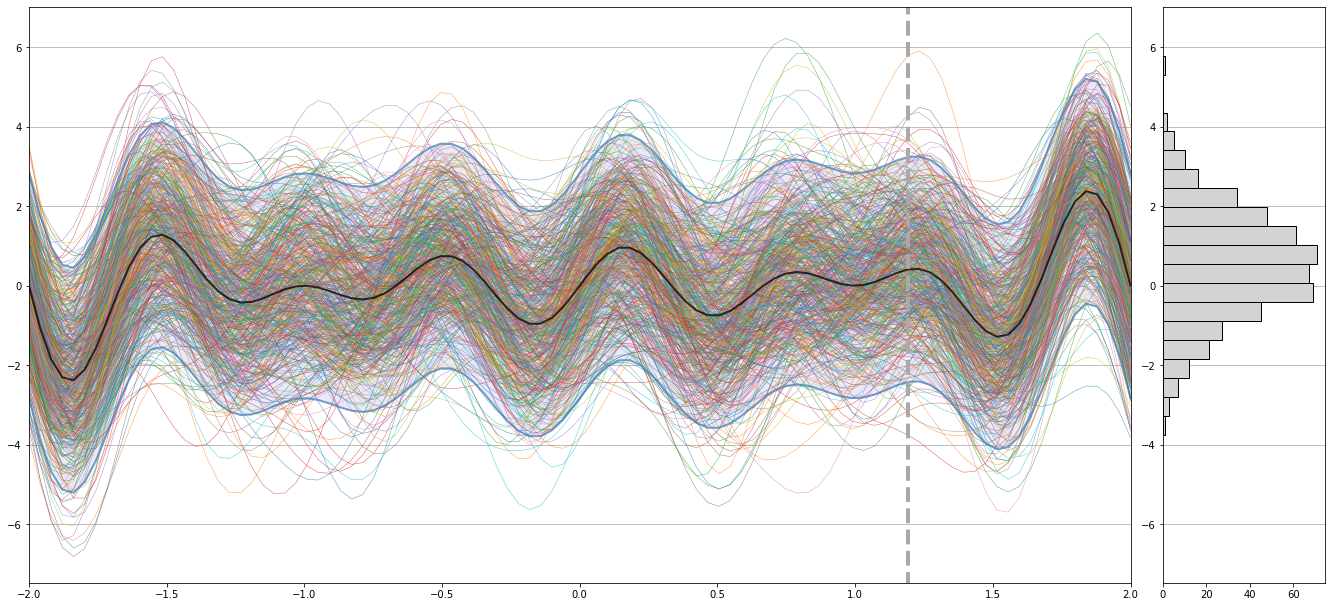

In [3]:
fig = plt.figure(figsize=(18., 8.), facecolor=None)
#
ax_l = fig.add_axes([0.0, 0.0, 0.85, 1.0])
ax_l.plot(x, f_prior, lw=0.5, alpha=0.75)
ax_l.fill_between(
    x, 
    y1=(m - 2.0 * sigma_vector),  # Two-sigma aounrd mean.
    y2=(m + 2.0 * sigma_vector),  # Two-sigma aounrd mean.
    color="lavender", alpha=0.85)
ax_l.plot(x, (m + 2.0 * sigma_vector), lw=2.0, color="steelblue", alpha=0.75)
ax_l.plot(x, (m - 2.0 * sigma_vector), lw=2.0, color="steelblue", alpha=0.75)
ax_l.plot(x, m, lw=2.0, color="black", alpha=0.75)
ax_l.axvline(x[slice_idx], *ax_l.get_ylim(), color="darkgray", lw=4.0, ls="--")
ax_l.set_xlim(np.amin(x), np.amax(x))
ax_l.grid(axis="y")
ax_l.set_axisbelow(True)
#
ax_r = fig.add_axes([0.875, 0.0, 0.125, 1.0], sharey=ax_l)
ax_r.hist(
    f_prior[slice_idx], bins=20, align="mid", rwidth=1.0, 
    orientation="horizontal", color="lightgray", edgecolor="black")
# ax_r.set_yticklabels([])
ax_r.grid(axis="y")
ax_r.set_axisbelow(True)
plt.show()

<br><br><br>
# Prior Distribution and Simulated Data

## Prior Distribution

In [4]:
n = 100         # Discretization of the function's input
n_samples = 20  # number of sample functions/vectors to draw

def mu(x):
    """Mean of the distribuion
    """
    return np.zeros_like(x) 
    
def kernel(x1, x2, l=0.5, sigma=1.0):
    """ Variance of the distribution.
    l controls the smoothness of the sample functions. It's a length scale.
    sigma controles the overal standard deviation/uncertaininty.
    """
    mx1, mx2 = np.meshgrid(x1, x2)
    x1mx2_squared = np.square(mx1 - mx2)
    return sigma * np.exp(-1.0 * x1mx2_squared / l)

x = np.linspace(-2.0, 2.0, n)
m = mu(x)
k = kernel(x, x, l=0.1, sigma=2.0)
l_cholesky_k = np.linalg.cholesky(k + 1.0e-5 * np.eye(n))

sigma_vector = np.linalg.norm(l_cholesky_k, axis=1)

f_prior = m[:, np.newaxis] + np.dot(l_cholesky_k, np.random.normal(size=(n, n_samples)))
print(f"Samples shape: {f_prior.shape}")

Samples shape: (100, 20)


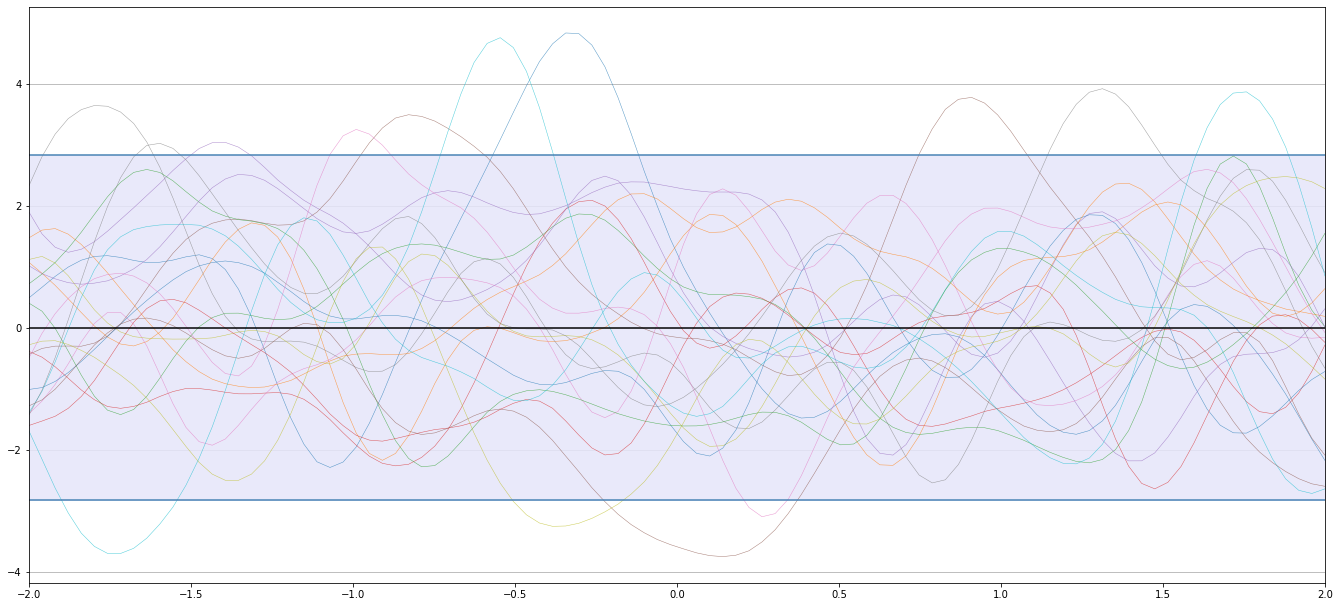

In [5]:
fig = plt.figure(figsize=(18., 8.), facecolor=None)
#
ax_l = fig.add_axes([0.0, 0.0, 1.0, 1.0])
ax_l.plot(x, f_prior, lw=0.5, alpha=0.75)
ax_l.fill_between(
    x, 
    y1=(m - 2.0 * sigma_vector),  # Two-sigma aounrd mean.
    y2=(m + 2.0 * sigma_vector),  # Two-sigma aounrd mean.
    color="lavender", alpha=0.85)
ax_l.plot(x, (m + 2.0 * sigma_vector), lw=2.0, color="steelblue", alpha=0.75)
ax_l.plot(x, (m - 2.0 * sigma_vector), lw=2.0, color="steelblue", alpha=0.75)
ax_l.plot(x, m, lw=2.0, color="black", alpha=0.75)
ax_l.set_xlim(np.amin(x), np.amax(x))
ax_l.grid(axis="y")
ax_l.set_axisbelow(True)
plt.show()

## Simulated Data

First, let's simulate some data. This data will be a linear function with some noise. When we treat this data as a noiseless data, we are in fact extracting a nonlinear dependence. Hence we rely only one set of points for the both cases of noisy and noiseless GP regression. 

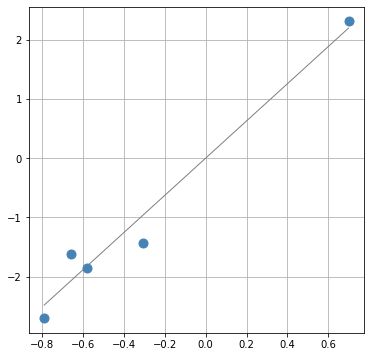

In [6]:
n = 200
sim_data_size = 5
w_data = np.pi
epsilon_data = 0.5

# Discretization of the functions:
x = np.linspace(-1, 1, n)

# Construct a mask for the observed points.
x_data_mask = np.zeros(n, dtype=bool)
data_idx_array = np.arange(n, dtype=np.uint32)
np.random.shuffle(data_idx_array)
data_idx_array = data_idx_array[0:sim_data_size]
x_data_mask[data_idx_array] = True

x_data = x[x_data_mask]
y_data = w_data * x_data + epsilon_data * np.random.randn(sim_data_size)

fig = plt.figure(figsize=(6., 6.))
plt.plot(x_data, y_data, ls="", marker="o", zorder=3, markersize=9.0, color="steelblue")
plt.plot(x_data, w_data * x_data, ls="-", lw=1.0, zorder=2, color="gray")
plt.grid(zorder=1)
plt.show()

In [7]:
kernel_l = 0.25
kernel_sigma = 1.0

k_dd = kernel(x_data, x_data, l=kernel_l, sigma=kernel_sigma) 
k_dy = kernel(
    x_data, x[np.logical_not(x_data_mask)], 
    l=kernel_l, sigma=kernel_sigma)
k_yy = kernel(
    x[np.logical_not(x_data_mask)], 
    x[np.logical_not(x_data_mask)], 
    l=kernel_l, sigma=kernel_sigma)

print(f"\tData Kernel Size:   {k_dd.shape}")
print(f"\tData-y Kernel Size: {k_dy.shape}")
print(f"\tyy Kernel Size:     {k_yy.shape}")

	Data Kernel Size:   (5, 5)
	Data-y Kernel Size: (195, 5)
	yy Kernel Size:     (195, 195)


<br><br><br>
# Noisy and Noiseless Posteriors

## Noiseless GP

In this case, we assume that the datapoints that we have reflect the true dependence of $y$ on $x$, i.e., the dependece of $y$ on $x$ is fully deterministic.

In [8]:
mu_star = np.dot(np.matmul(k_dy, np.linalg.inv(k_dd)), y_data) 
k_star = k_yy - np.matmul(np.matmul(k_dy, np.linalg.inv(k_dd)), np.transpose(k_dy))

print(f"\tNew Mean Vector:   {mu_star.shape}")
print(f"\tNew Kernel Matrix: {k_star.shape}")

	New Mean Vector:   (195,)
	New Kernel Matrix: (195, 195)


In [9]:
n_star = n - sim_data_size
x_star = x[np.logical_not(x_data_mask)]

l_cholesky_k = np.linalg.cholesky(k_star + 1.0e-5 * np.eye(n_star))
sigma_posterior = np.linalg.norm(l_cholesky_k, axis=1)

f_posterior = mu_star[:, np.newaxis] + np.dot(
    l_cholesky_k, np.random.normal(size=(n_star, n_samples)))

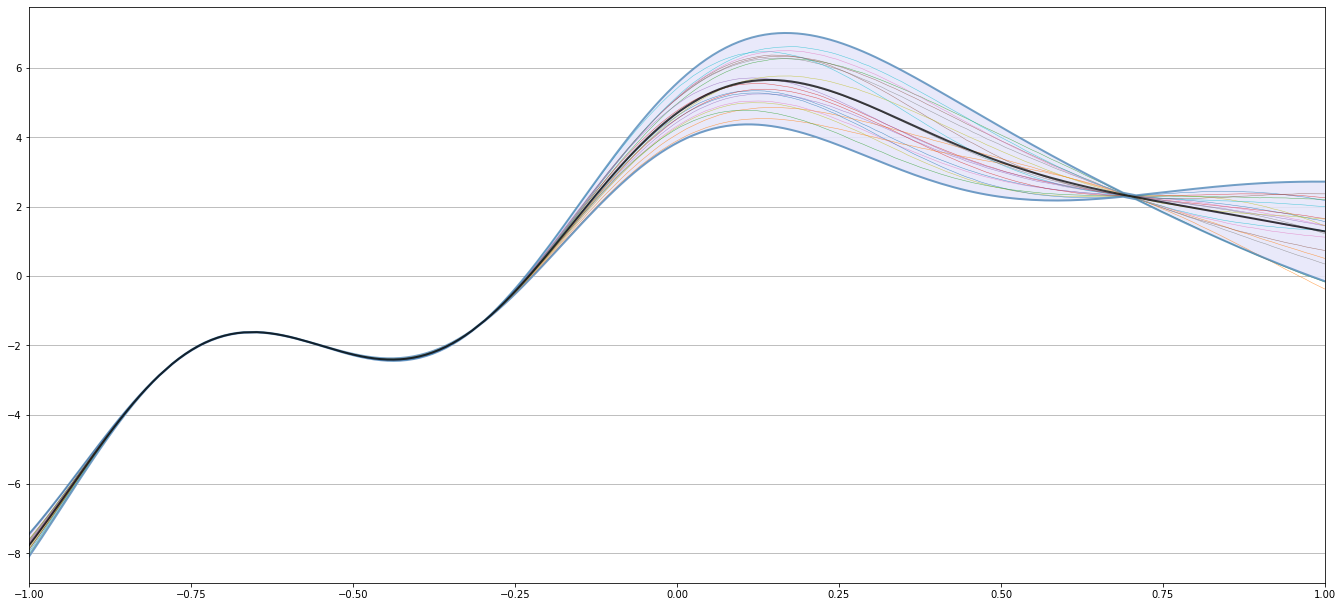

In [10]:
fig = plt.figure(figsize=(18., 8.), facecolor=None)
#
ax_l = fig.add_axes([0.0, 0.0, 1.0, 1.0])
ax_l.plot(x_star, f_posterior, lw=0.5, alpha=0.75)
ax_l.fill_between(
    x_star, 
    y1=(mu_star - 2.0 * sigma_posterior),  # Two-sigma aounrd mean.
    y2=(mu_star + 2.0 * sigma_posterior),  # Two-sigma aounrd mean.
    color="lavender", alpha=0.85)
ax_l.plot(x_star, (mu_star + 2.0 * sigma_posterior), lw=2.0, color="steelblue", alpha=0.75)
ax_l.plot(x_star, (mu_star - 2.0 * sigma_posterior), lw=2.0, color="steelblue", alpha=0.75)
ax_l.plot(x_star, mu_star, lw=2.0, color="black", alpha=0.75)
ax_l.set_xlim(np.amin(x), np.amax(x))
ax_l.grid(axis="y")
ax_l.set_axisbelow(True)
plt.show()

## Noisy GP Regression

This time, let's assume that the data that we will use to update our prior contains some noise. 

In [11]:
sigma_noise_prior = 0.2

k_dd_noisy = k_dd + sigma_noise_prior ** 2 * np.eye(k_dd.shape[0])
mu_star_noisy = np.dot(np.matmul(k_dy, np.linalg.inv(k_dd_noisy)), y_data) 
k_star_noisy = k_yy - np.matmul(np.matmul(k_dy, np.linalg.inv(k_dd_noisy)), np.transpose(k_dy))

print(f"\tNew Mean Vector:   {mu_star_noisy.shape}")
print(f"\tNew Kernel Matrix: {k_star_noisy.shape}")

	New Mean Vector:   (195,)
	New Kernel Matrix: (195, 195)


In [12]:
n_star = n - sim_data_size
x_star = x[np.logical_not(x_data_mask)]

l_cholesky_k = np.linalg.cholesky(k_star_noisy + 1.0e-6 * np.eye(n_star))
sigma_posterior = np.linalg.norm(l_cholesky_k, axis=1)

f_posterior = mu_star_noisy[:, np.newaxis] + np.dot(
    l_cholesky_k, np.random.normal(size=(n_star, n_samples)))

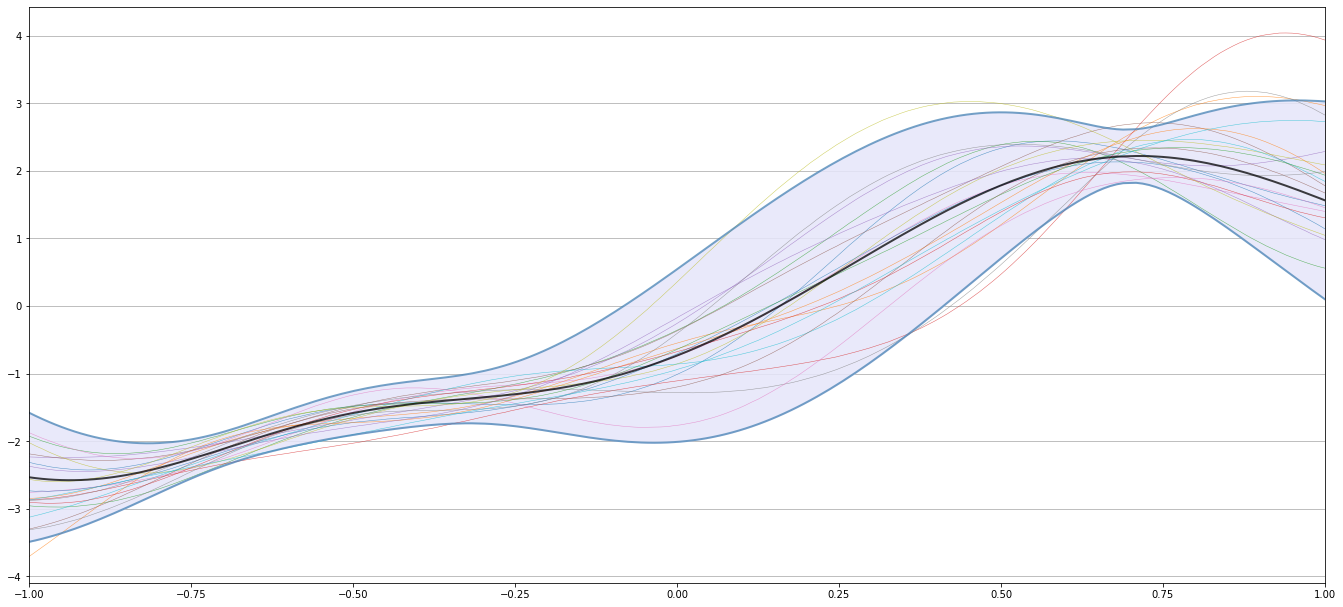

In [13]:
fig = plt.figure(figsize=(18., 8.), facecolor=None)
#
ax_l = fig.add_axes([0.0, 0.0, 1.0, 1.0])
ax_l.plot(x_star, f_posterior, lw=0.5, alpha=0.75)
ax_l.fill_between(
    x_star, 
    y1=(mu_star_noisy - 2.0 * sigma_posterior),  # Two-sigma aounrd mean.
    y2=(mu_star_noisy + 2.0 * sigma_posterior),  # Two-sigma aounrd mean.
    color="lavender", alpha=0.85)
ax_l.plot(x_star, (mu_star_noisy + 2.0 * sigma_posterior), lw=2.0, color="steelblue", alpha=0.75)
ax_l.plot(x_star, (mu_star_noisy - 2.0 * sigma_posterior), lw=2.0, color="steelblue", alpha=0.75)
ax_l.plot(x_star, mu_star_noisy, lw=2.0, color="black", alpha=0.75)
ax_l.set_xlim(np.amin(x), np.amax(x))
ax_l.grid(axis="y")
ax_l.set_axisbelow(True)
plt.show()